In [8]:
%pylab inline
from matplotlib import ticker
import sys
sys.path.append('../')
from astropy.table import Table,join
from astropy.stats import sigma_clip
import bokrmphot

Populating the interactive namespace from numpy and matplotlib


In [2]:
sdssRef = bokrmphot.load_catalog('sdss')['catalog']

In [10]:
def phot_stats(lcs,refPhot):
    from scipy.stats import scoreatpercentile
    band = 'g'
    apNum = 3
    if len(lcs.groups)==1:
        lcs = lcs.group_by('objId')
    medges = np.arange(16.9,19.11,0.2)
    mbins = medges[:-1] + np.diff(medges)/2
    all_dmag = []
    all_stds = []
    for mag1,mag2 in zip(medges[:-1],medges[1:]):
        ref_ii = np.where((refPhot[band]>mag1)&(refPhot[band]<mag2))[0]
        jj = np.where(np.in1d(lcs.groups.keys['objId'],ref_ii))[0]
        dmag = []
        stds = []
        for j in jj:
            mags = np.ma.masked_array(lcs.groups[j]['aperMag'][:,apNum],
                          mask=( (lcs.groups[j]['flags'][:,apNum]>0) |
                                 (lcs.groups[j]['aperMag'][:,apNum]>99) ) )
            if mags.mask.all():
                continue
            mags = sigma_clip(mags,iters=1,sigma=5.0)
            dmag.append((mags-mags.mean()).compressed())
            stds.append((mags-mags.mean()).std())
        dmag = np.concatenate(dmag)
        stds = np.array(stds)
        print '%.1f < m < %.1f  %3d / %3d matched --> %.3f %.3f' % \
               (mag1,mag2,len(jj),len(ref_ii),dmag.std(),np.median(stds))
        all_dmag.append(dmag)
        all_stds.append([scoreatpercentile(stds,_p) for _p in [25,50,75]])
    all_stds = np.array(all_stds)
    return all_dmag,all_stds

In [5]:
#sdssRefSep2014 = Table.read('../bokrmpipe_old/lightcurves_g.fits')
sdssRefNov2015 = Table.read('../bokrmpipe_old/lightcurves_g.fits')
sdssRefJan2017 = Table.read('../lightcurves_bokrm_sdss_g.fits')

In [11]:
nov15_dmag,nov15_stds = phot_stats(sdssRefNov2015,sdssRef)

16.9 < m < 17.1  160 / 189 matched --> 0.170 0.014
17.1 < m < 17.3  202 / 241 matched --> 0.064 0.015
17.3 < m < 17.5  201 / 242 matched --> 0.033 0.015
17.5 < m < 17.7  222 / 262 matched --> 0.036 0.016
17.7 < m < 17.9  263 / 305 matched --> 0.081 0.016
17.9 < m < 18.1  273 / 319 matched --> 0.025 0.018
18.1 < m < 18.3  304 / 343 matched --> 0.044 0.019
18.3 < m < 18.5  318 / 384 matched --> 0.104 0.020
18.5 < m < 18.7  335 / 403 matched --> 0.043 0.022
18.7 < m < 18.9  339 / 435 matched --> 0.041 0.025
18.9 < m < 19.1  381 / 449 matched --> 0.062 0.029


In [12]:
jan17_dmag,jan17_stds = phot_stats(sdssRefJan2017,sdssRef)

16.9 < m < 17.1  160 / 189 matched --> 0.050 0.012
17.1 < m < 17.3  202 / 241 matched --> 0.025 0.013
17.3 < m < 17.5  201 / 242 matched --> 0.040 0.013
17.5 < m < 17.7  221 / 262 matched --> 0.019 0.014
17.7 < m < 17.9  263 / 305 matched --> 0.047 0.014
17.9 < m < 18.1  273 / 319 matched --> 0.020 0.015
18.1 < m < 18.3  303 / 343 matched --> 0.023 0.016
18.3 < m < 18.5  318 / 384 matched --> 0.028 0.018
18.5 < m < 18.7  335 / 403 matched --> 0.031 0.020
18.7 < m < 18.9  339 / 435 matched --> 0.031 0.021
18.9 < m < 19.1  379 / 449 matched --> 0.055 0.025


In [18]:
def plot_compare_scatters(stdslist,labels,colors='rgbcymk',filt='g'):
    medges = np.arange(16.9,19.11,0.2)
    mbins = medges[:-1] + np.diff(medges)/2
    def _append_arr(arr):
        return arr
        # used this for drawstyle=steps-post, but no equiv. for fill_between
        #return np.concatenate([arr,[arr[-1]]])
    figure()
    for s,l,c in zip(stdslist,labels,colors):
        fill_between(mbins,_append_arr(s[:,0]),_append_arr(s[:,2]),
                     edgecolor='none',color=c,alpha=0.5)
        plot(mbins,_append_arr(s[:,1]),color=c,lw=1.5,label=l)
    legend(loc='upper left')
    xlabel('%s magnitude' % filt)
    ylabel('per-object std [mag]')

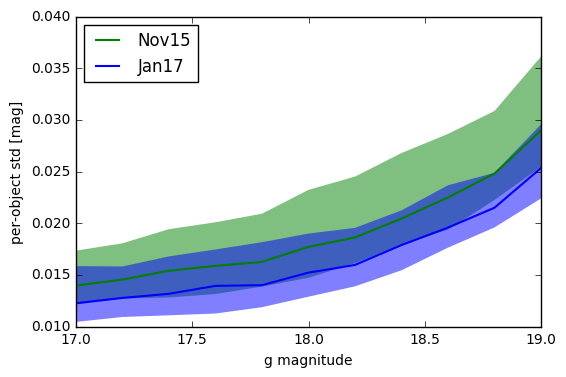

In [19]:
plot_compare_scatters([nov15_stds,jan17_stds],['Nov15','Jan17'],'gb')